In [49]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import corner

%matplotlib inline

### Tycho-2 Catalog

In [43]:
# Read in sample from Tycho-2 table

filename = ('../data/tycho-2/tyc2.dat')
readme = ('../data/tycho-2/ReadMe')
t = Table.read(filename, format='cds', guess=False, readme=readme)

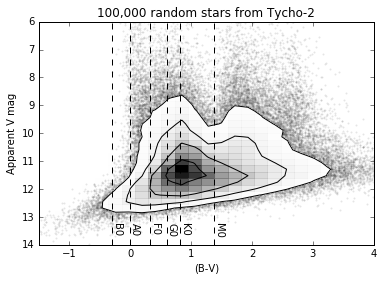

In [55]:
BT = t["BTmag"]
VT = t["VTmag"]
# We can adjust to Johnson magnitudes using conversion from http://www.britastro.org/asteroids/Tycho%20Photometry.htm
V_mag = t["VTmag"] - 0.016 - 0.0741 * (t["BTmag"] - t["VTmag"])
B_mag = t["BTmag"] + 0.064 + 0.2983 * (t["BTmag"] - t["VTmag"])
BV_color = B_mag - V_mag
# From http://stupendous.rit.edu/tass/catalogs/tycho.html (Mamajek, Meyer, & Liebert 2002)
#V_mag = VT + 9.7e-4 - 0.1334*(BT-VT) + 5.486e-2*(BT-VT)**2 - 1.998e-2*(BT-VT)**3
#BV_color = BT-VT - 7.813e-3*(BT-VT) - 1.489e-1*(BT-VT)**2 + 3.384e-2*(BT-VT)**3
#BV_color[np.where(BT-VT < 0.5)] = BT-VT - 0.006 - 1.069e-1*(BT-VT) + 1.459e-1*(BT-VT)**2

#plt.scatter(BV_color, V_mag, marker='.', color='k', alpha=0.05)
corner.hist2d(BV_color, V_mag, bins=50)

plt.xlabel("(B-V)")
plt.ylabel("Apparent V mag")
plt.title("100,000 random stars from Tycho-2")

plt.xlim(-1.5, 4.0)
plt.ylim(14, 6)

# Add lines linking colors to stellar type
# Values from http://www.stsci.edu/~inr/intrins.html (Ducati et al. 2001)
plt.axvline(-0.3, color='k', linestyle='dashed') # B0 star
plt.text(-0.3,13.5,'B0',rotation=-90)
plt.axvline(-0.01, color='k', linestyle='dashed') # A0 star
plt.text(-0.01,13.5,'A0',rotation=-90)
plt.axvline(0.32, color='k', linestyle='dashed') # F0 star
plt.text(0.32,13.5,'F0',rotation=-90)
plt.axvline(0.60, color='k', linestyle='dashed') # G0 star
plt.text(0.6,13.5,'G0',rotation=-90)
plt.axvline(0.81, color='k', linestyle='dashed') # K0 star
plt.text(0.81,13.5,'K0',rotation=-90)
plt.axvline(1.37, color='k', linestyle='dashed') # M0 star
plt.text(1.37,13.5,'M0',rotation=-90)

plt.savefig('../figures/tycho2_colors.pdf')
#plt.show()

### Tycho-2 Double Star Catalog

In [2]:
# Read in Tycho-2 Double Star Catalog table

filename = ('../data/TDSC/catalog.dat')
readme = ('../data/TDSC/ReadMe')
t_TDSC = Table.read(filename, format='ascii.fixed_width_no_header')

In [56]:
# Binary id
ID = t_TDSC['col1']

# Photometry
B_tyc = t_TDSC['col17']
V_tyc = t_TDSC['col19']

# Position
ra = t_TDSC['col5']
ra_err = t_TDSC['col7']
dec = t_TDSC['col6']
dec_err = t_TDSC['col8']

# Proper motion
mu_ra = t_TDSC['col12']
mu_ra_err = t_TDSC['col14']
mu_dec = t_TDSC['col13']
mu_dec_err = t_TDSC['col15']

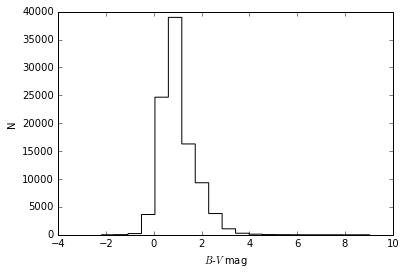

In [16]:
V_mag = V_tyc - 0.016 - 0.0741 * (B_tyc - V_tyc)
B_mag = B_tyc + 0.064 + 0.2983 * (B_tyc - V_tyc)


plt.hist(B_mag - V_mag, histtype='step', color='k', bins=20)
plt.xlabel(r'$B$-$V$ mag')
plt.ylabel('N')

plt.show()

In [80]:
def sep_degree(ra1, dec1, ra2, dec2):
    return np.sqrt((ra1-ra2)**2 * np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)

theta = np.array([])

for i in np.arange(len(t_TDSC)):
    if t_TDSC['col2'][i] == "A":
        ra1 = ra[i]
        dec1 = dec[i]
        continue
    
    ra2 = ra[i]
    dec2 = dec[i]
    
    theta = np.append(theta, sep_degree(ra1, dec1, ra2, dec2))
    
# theta is in degrees. Let's change to arcseconds
theta = theta * 3600.0

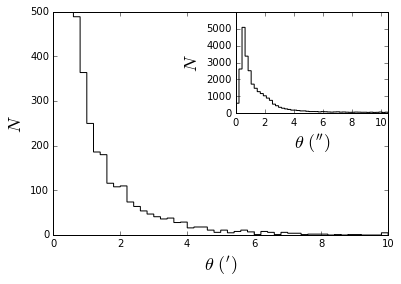

In [104]:
fig = plt.figure()

plt.hist(theta/60.0, histtype='step', range=[0.0, 10.0], color='k', bins=50)
plt.ylim(0.0, 500)
plt.xlim(0.0, 10.0)
plt.xlabel(r'$\theta\ (^{\prime})$', fontsize=18)
plt.ylabel(r'$N$', fontsize=18)

ax1 = fig.add_subplot(222)
ax1.hist(theta, histtype='step', range=[0.0,10.5], color='k', bins=50)
ax1.set_xlim(0.0, 10.5)
ax1.set_xlabel(r'$\theta\ (^{\prime\prime})$', fontsize=18)
ax1.set_ylabel(r'$N$', fontsize=18)
ax1.set_yticks([0, 1000, 2000, 3000, 4000, 5000])

plt.tight_layout()
plt.savefig('../figures/TDSC_separation.pdf')
#plt.show()